In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

### First, let's prepare the data

In [2]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_POLINA.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

#Creating final dataset
data = pd.merge(specs[['ID_library', 'smiles']], sss_batchA[['ID_covid', 'Intensity_MeanIntensity_illumMITO_cells.1']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data = data.drop([5164])
print(f"There are {len(data)} rows in data")
data.head() 

There are 5171 rows in data


,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333


Remove duplicated columns

In [3]:
# Look for duplicated columns

dup_cols = fun.getDuplicateColumns(sss_batchA)
print(f'The duplicate columns are:\n {dup_cols}')

The duplicate columns are:
 ['AreaShape_MinFeretDiameter_cytoplasm', 'AreaShape_MaxFeretDiameter_cytoplasm', 'AreaShape_BoundingBoxMaximum_X_cytoplasm', 'AreaShape_BoundingBoxMinimum_X_cytoplasm', 'AreaShape_BoundingBoxMaximum_Y_cytoplasm', 'AreaShape_BoundingBoxArea_cytoplasm', 'AreaShape_BoundingBoxMinimum_Y_cytoplasm', 'Location_Center_Y_cells', 'Location_Center_X_cytoplasm', 'Location_Center_X_nuclei', 'Location_Center_Y_cytoplasm', 'Location_Center_Y_nuclei', 'Location_Center_X_cells', 'Intensity_MeanIntensity_illumMITO_cells.1']


In [4]:
dup_cols[-1] = 'Intensity_MeanIntensity_illumMITO_cells'

In [5]:
# Check if Intensity_MeanIntensity_illumMITO_cells is a repeate column
#sss_batchA['Intensity_MeanIntensity_illumMITO_cells'].equals(sss_batchA['Intensity_MeanIntensity_illumMITO_cells.1'])
#sss_batchA = sss_batchA.drop(['Intensity_MeanIntensity_illumMITO_cells'], axis=1)
sss_batchA = sss_batchA.drop(dup_cols, axis=1)

In [6]:
#Creating molecule objects
data['MOL'] = data['smiles'].apply(fun.standardize)
data.head()

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."


In [7]:
# Check if any of the SMILES contain multiple fragments - 
# this can sometimes cause issues when computing descriptors
data['FRAGS'] =  data['MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))
print("Fragments: {0}".format(data['FRAGS'].nunique()))

Fragments: 1


We can continue wirh clean data

### Now we add the information for training

First the cell profiler

In [8]:
#Remove columns that are "human-made", hence, not useful 
cell_profiler = sss_batchA.drop(['PlateWellCompound','principal component 1','Intensity_MeanIntensity_illumMITO_cells.1','Ypredicted','Labels'], 1)
cell_profiler.head()

#Create a vector that takes only the info from the cell profiler. NOTE: it is important to keep the ID intact for future merging
cell_profiler['cell_profiler_vector'] = cell_profiler.apply(lambda r: tuple(r[0:-1]), axis=1).apply(np.array)
cell_profiler.head(2)

<ipython-input-8-7caa737e78b0>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cell_profiler = sss_batchA.drop(['PlateWellCompound','principal component 1','Intensity_MeanIntensity_illumMITO_cells.1','Ypredicted','Labels'], 1)


,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,ID_covid,cell_profiler_vector
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,CBK310026,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,CBK310025,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."


In [9]:
#Creating final dataset
data = pd.merge(data, cell_profiler[['ID_covid', 'cell_profiler_vector']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data.head() 

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL,FRAGS,cell_profiler_vector
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[177.625, 1720.288161, 2334.18884, 1099.896167..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[205.4444444, 1688.236028, 2286.442354, 1091.8..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[204.7777778, 1708.759477, 2319.240635, 1091.1..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[193.8888889, 1647.879668, 2244.319157, 1201.7..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[200.2222222, 1667.427461, 2269.049919, 1138.2..."


Adding fingerprints

In [10]:
# Parameters for features
morgan_radius = 3
morgan_n_bits = 2048
fp_n_bits = 2048

# Feature creation
X_morgan, _ = fun.feature_creation(morgan_radius, morgan_n_bits, fp_n_bits, data)

In [11]:
data['Morgan_fgp_vector'] = X_morgan.tolist()
data.head(5)

,ID_library,smiles,Intensity_MeanIntensity_illumMITO_cells.1,MOL,FRAGS,cell_profiler_vector,Morgan_fgp_vector
0,CBK000155,C[C@H](Cc1ccc(OCC([O-])=O)cc1)NC[C@H](O)c1cccc...,0.010426,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[177.625, 1720.288161, 2334.18884, 1099.896167...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CBK000156,CC(C)(C)NCC(O)COc1cccc2[nH]c(=O)[nH]c12,0.009417,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[205.4444444, 1688.236028, 2286.442354, 1091.8...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CBK000161,[H][C@@](CC)(NC(C)C)[C@]([H])(O)c1ccc(O)c2[nH]...,0.008106,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[204.7777778, 1708.759477, 2319.240635, 1091.1...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CBK000162,CC(C)N[C@@H](C)[C@@H](O)COc1ccc(C)c2CCCc12,0.010586,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[193.8888889, 1647.879668, 2244.319157, 1201.7...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CBK000164,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.010333,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",1,"[200.2222222, 1667.427461, 2269.049919, 1138.2...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [12]:
name = r'/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/UniqueOnly_data_BatchA.csv'
data.to_csv(name, sep=',', encoding='utf-8',index=False)

## Now training

In [15]:
# We get the input values
X = data['cell_profiler_vector'].tolist()
X = np.asarray(X)
# Output values
y = data['Intensity_MeanIntensity_illumMITO_cells.1'].values
# Re-scale
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25435)

### Linear regression with only real values

In [17]:
# Training
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
# Computing predictions
y_pred = regressor.predict(X_test)
# Accessing results
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

In [18]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.58167649864408e-09
Mean Squared Error: 5.569627598183692e-17
Root Mean Squared Error: 7.462993768042213e-09


In [20]:
df = fun.labelling_v2(fun.labelling_v2(df, 'Actual',1, 1, 0, 0.0062), 'Predicted',3, 1, 0, 0.0062)
df['Labels_Actual'].equals(df['Labels_Predicted'])

True

### Regression with binary input and real targets

In [27]:
# Extract training data
X_mo = data['Morgan_fgp_vector'].tolist()
X_mo = np.asarray(X_mo)

In [29]:
X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(X_mo, y, test_size=0.2, random_state=25435)

In [30]:
regressor_mo = LinearRegression() 
regressor_mo.fit(X_train_mo, y_train_mo) #training the algorithm
# Computing predictions
y_pred_mo = regressor_mo.predict(X_test_mo)
# Accessing results
df = pd.DataFrame({'Actual': y_test_mo.flatten(), 'Predicted': y_pred_mo.flatten()})

In [33]:
print('Mean Absolute Error:', mean_absolute_error(y_test_mo, y_pred_mo))  
print('Mean Squared Error:', mean_squared_error(y_test_mo, y_pred_mo))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_mo, y_pred_mo)))

Mean Absolute Error: 0.0011367527507192084
Mean Squared Error: 2.1706844270257894e-06
Root Mean Squared Error: 0.0014733242776204393


In [34]:
df = fun.labelling_v2(fun.labelling_v2(df, 'Actual',1, 1, 0, 0.0062), 'Predicted',3, 1, 0, 0.0062)
#df['Labels_Actual'].equals(df['Labels_Predicted'])

In [40]:
df.loc[df['Labels_Actual']==1]

,Actual,Labels_Actual,Predicted,Labels_Predicted
23,0.005876,1,0.009248,0
126,0.006189,1,0.010388,0
384,0.005660,1,0.007088,0
387,0.006019,1,0.008503,0
950,0.005311,1,0.009331,0
988,0.005010,1,0.008270,0
999,0.006163,1,0.010014,0
1022,0.005507,1,0.010072,0


In [42]:
cd_mo = confusion_matrix(df['Labels_Actual'].tolist(), df['Labels_Predicted'].tolist())

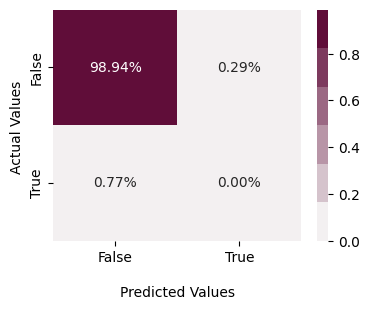

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = sns.heatmap(cd_mo/np.sum(cd_mo), annot=True, fmt = '.2%', cmap=sns.light_palette((.376, .051, .224)), ax=ax)
#ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### SVM for regression

In [60]:
from sklearn import svm
regr_svm_mo = svm.SVR(kernel='poly', degree = 7)
regr_svm_mo.fit(X_train_mo, y_train_mo) #training the algorithm
# Computing predictions
y_pred_svm_mo = regr_svm_mo.predict(X_test_mo)
# Evaluate
df_svm_mo = pd.DataFrame({'Actual': y_test_mo.flatten(), 'Predicted': y_pred_svm_mo.flatten()})
df_svm_mo = fun.labelling_v2(fun.labelling_v2(df_svm_mo, 'Actual',1, 1, 0, 0.0062), 'Predicted',3, 1, 0, 0.0062)
cf_svm_mo = confusion_matrix(df_svm_mo['Labels_Actual'].tolist(), df_svm_mo['Labels_Predicted'].tolist())
cf_svm_mo

array([[1027,    0],
       [   8,    0]])

### Lasso Regression

In [65]:
from sklearn import linear_model
reg_lss_mo = linear_model.Lasso(alpha=0.1)
reg_lss_mo.fit(X_train_mo, y_train_mo) #training the algorithm
# Computing predictions
y_pred_lss_mo = reg_lss_mo.predict(X_test_mo)
# Evaluate
df_lss_mo = pd.DataFrame({'Actual': y_test_mo.flatten(), 'Predicted': y_pred_lss_mo.flatten()})
df_lss_mo = fun.labelling_v2(fun.labelling_v2(df_lss_mo, 'Actual',1, 1, 0, 0.0062), 'Predicted',3, 1, 0, 0.0062)
cf_lss_mo = confusion_matrix(df_lss_mo['Labels_Actual'].tolist(), df_lss_mo['Labels_Predicted'].tolist())
cf_lss_mo

array([[1027,    0],
       [   8,    0]])

### ************************** Regression with only binary data

In [27]:
df_morgan_data = data[['ID_library','Intensity_MeanIntensity_illumMITO_cells.1','Morgan_fgp_vector']]
df_morgan_data.head(5)

counter = 0
score_list_x_tr = []
score_matrix = []
cf_list_x_tr = []
cf_matrix = []

u = 0.5 # Under sampling rate


for tr in np.arange(0.0062,0.0082,0.0004):
    
    # ------ Classifier:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 100, random_state = 84723)
    # ------ Sampling method
    under_sampler = RandomUnderSampler(sampling_strategy = u ,random_state=42)
    
    print(f'************ Experiment {counter}')
    print(f'Threshold = {tr}')
    
    # Get labels according to the threshold
    df_training_mo = fun.labelling_v2(data = df_morgan_data.copy(), col_reference = 'Intensity_MeanIntensity_illumMITO_cells.1', 
                     labels_position = 3, label_positive = 1, label_negative = 0, threshold = tr)

    
    df_training_mo_duplicates = df_training_mo[df_training_mo['Morgan_fgp_vector'].duplicated(keep=False)]
    # Create a df with unique Morgan fg only
    df_training_mo = df_training_mo.drop(df_training_mo_duplicates.index.tolist())
    # Check if there are positive labels. Drop al the rest
    df_training_mo_duplicates = df_training_mo_duplicates[df_training_mo_duplicates['Labels_Intensity_MeanIntensity_illumMITO_cells.1']==1]
    # Merge to obtain clean df
    df_training_mo = pd.concat([df_training_mo, df_training_mo_duplicates])
    # Double check <<<<<<<<<<<<<<<<<<<<I MAY HAVE TO ADD MORE HERE
    if len(df_training_mo[df_training_mo['Morgan_fgp_vector'].duplicated(keep=False)]) > 0:
        print('There are repetitions.... Stopping')
        break
    else:
        print('Vamos bien...')
        
    X_morgan = df_training_mo['Morgan_fgp_vector'].tolist()
    X_morgan = np.asarray(X_morgan)
    y = df_training_mo['Labels_Intensity_MeanIntensity_illumMITO_cells.1'].values
    print(f'Class count in Batch A:\n {Counter(y)}')
    
    # Split proportionally
    X_train, X_test, y_train, y_test = train_test_split(X_morgan, y, test_size=0.2, stratify=y, random_state=6752)
    print(f'Class count in TRAIN: {Counter(y_train)}')
    print(f'Class count in TEST: {Counter(y_test)}')

    # fit and apply the transform
    x_train_re_un, y_train_re_un = under_sampler.fit_resample(X_train, y_train)
    
    # summarize class distribution
    print('Under-sampling with (u = {}). Final count: {}'.format(u, Counter(y_train_re_un)))

    #------- Training and evaluating
    clf.fit(x_train_re_un, y_train_re_un)
    y_predicted_re_un = clf.predict(X_test)
    score = f1_score(y_test, y_predicted_re_un)
    print(f'---F1-score: {score}')

    score_list.append(score)
    counter += 1
    
    df_training_mo = df_training_mo.drop('Labels_Intensity_MeanIntensity_illumMITO_cells.1', axis = 1)

************ Experiment 0
Threshold = 0.0062
[16, 122, 123, 257, 274, 279, 621, 622, 680, 703, 704, 734, 736, 753, 894, 1009, 1071, 1275, 1335, 1562, 1977, 1981, 1982, 2531, 2931, 3126, 3137, 3144, 3160, 3183, 3196, 3221, 3275, 3329, 3493, 3877, 3899, 3947, 3948, 4585, 4607, 4694, 4706, 4710, 4718, 4753, 4843, 5012, 5147, 5150, 5152, 5155]
Vamos bien...
Class count in Batch A:
 Counter({0: 5069, 1: 51})
Class count in TRAIN: Counter({0: 4055, 1: 41})
Class count in TEST: Counter({0: 1014, 1: 10})
Under-sampling with (u = 0.5). Final count: Counter({0: 82, 1: 41})
---F1-score: 0.08
************ Experiment 1
Threshold = 0.0066
[16, 122, 123, 257, 274, 279, 621, 622, 680, 703, 704, 734, 736, 753, 894, 1009, 1071, 1275, 1335, 1562, 1977, 1981, 1982, 2531, 2931, 3126, 3137, 3144, 3160, 3183, 3196, 3221, 3275, 3329, 3493, 3877, 3899, 3947, 3948, 4585, 4607, 4694, 4706, 4710, 4718, 4753, 4843, 5012, 5147, 5150, 5152, 5155]
Vamos bien...
Class count in Batch A:
 Counter({0: 5047, 1: 73})
Class

In [46]:
np.array(score_matrix)

array([[0.44444444, 0.15      , 0.10958904, 0.06779661, 0.08      ,
        0.06557377, 0.05454545, 0.04428044, 0.03821656, 0.03966006],
       [0.125     , 0.15873016, 0.08264463, 0.09615385, 0.05194805,
        0.06930693, 0.06113537, 0.0536193 , 0.04295943, 0.04534005],
       [0.1025641 , 0.17142857, 0.1512605 , 0.15942029, 0.12154696,
        0.08144796, 0.1031746 , 0.07792208, 0.07831325, 0.06132075],
       [0.18181818, 0.15929204, 0.12820513, 0.12903226, 0.11914894,
        0.09937888, 0.10932476, 0.10810811, 0.07246377, 0.08947368],
       [0.06976744, 0.13445378, 0.12765957, 0.096     , 0.09966777,
        0.12276215, 0.08823529, 0.10714286, 0.11666667, 0.10970464],
       [0.125     , 0.10891089, 0.18113208, 0.1580756 , 0.15384615,
        0.145     , 0.16243655, 0.1356674 , 0.14624506, 0.15      ]])

Second experiment: using class weights

In [49]:
df_morgan_data = data[['ID_library','Intensity_MeanIntensity_illumMITO_cells.1','Morgan_fgp_vector']]

counter = 0
score_matrix2 = []
cf_matrix2 = []

for tr in np.arange(0.0062,0.0082,0.0004):
    
    print(f'************ Experiment {counter}')
    print(f'*Threshold = {tr}')   
    
    score_list_x_tr = []
    cf_list_x_tr = []
    
    
    # Get labels according to the threshold
    df_training_mo = fun.labelling_v2(data = df_morgan_data.copy(), col_reference = 'Intensity_MeanIntensity_illumMITO_cells.1', 
                     labels_position = 3, label_positive = 1, label_negative = 0, threshold = tr)


    df_training_mo_duplicates = df_training_mo[df_training_mo['Morgan_fgp_vector'].duplicated(keep=False)]
    # Create a df with unique Morgan fg only
    df_training_mo = df_training_mo.drop(df_training_mo_duplicates.index.tolist())
    # Check if there are positive labels. Drop al the rest
    df_training_mo_duplicates = df_training_mo_duplicates[df_training_mo_duplicates['Labels_Intensity_MeanIntensity_illumMITO_cells.1']==1]
    # Merge to obtain clean df
    df_training_mo = pd.concat([df_training_mo, df_training_mo_duplicates])
    # Double check <<<<<<<<<<<<<<<<<<<<I MAY HAVE TO ADD MORE HERE
    if len(df_training_mo[df_training_mo['Morgan_fgp_vector'].duplicated(keep=False)]) > 0:
        print('There are repetitions.... Stopping')
        break
    else:
        print('Vamos bien...')

    X_morgan = df_training_mo['Morgan_fgp_vector'].tolist()
    X_morgan = np.asarray(X_morgan)
    y = df_training_mo['Labels_Intensity_MeanIntensity_illumMITO_cells.1'].values
    print(f' Class count in Batch A: {Counter(y)}')

    # Split proportionally
    X_train, X_test, y_train, y_test = train_test_split(X_morgan, y, test_size=0.2, stratify=y, random_state=6752)
    #print(f' Class count in TRAIN: {Counter(y_train)}')
    #print(f' Class count in TEST: {Counter(y_test)}')

    for u in np.arange(0.1,1.1,0.1):    # LOOP ON THE UNDERSAMPLING RATIO
    
        # ------ Classifier:
        weights = {0:1.0, 1:10.0}
        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, class_weight=weights), n_estimators = 100, random_state = 84723)
        # ------ Sampling method
        under_sampler = RandomUnderSampler(sampling_strategy = u ,random_state=42)

        print(f'*Ratio = {u}')
        
        # fit and apply the transform
        x_train_re_un, y_train_re_un = under_sampler.fit_resample(X_train, y_train)

        # summarize class distribution
        print(' Under-sampling with (u = {}). Final count: {}'.format(u, Counter(y_train_re_un)))

        #------- Training and evaluating
        clf.fit(x_train_re_un, y_train_re_un)
        y_predicted_re_un = clf.predict(X_test)
        score = f1_score(y_test, y_predicted_re_un)
        conf_matrix = confusion_matrix(y_test, y_predicted_re_un)
        print(f' --- F1-score: {score}')
        
        cf_list_x_tr.append(conf_matrix)
        score_list_x_tr.append(score)
        
    # Clean dataframe
    df_training_mo = df_training_mo.drop('Labels_Intensity_MeanIntensity_illumMITO_cells.1', axis = 1)
        
    score_matrix2.append(score_list_x_tr)
    cf_matrix2.append(cf_list_x_tr)
    counter += 1

************ Experiment 0
*Threshold = 0.0062
Vamos bien...
 Class count in Batch A: Counter({0: 5069, 1: 51})
*Ratio = 0.1
 Under-sampling with (u = 0.1). Final count: Counter({0: 410, 1: 41})
 --- F1-score: 0.1818181818181818
*Ratio = 0.2
 Under-sampling with (u = 0.2). Final count: Counter({0: 205, 1: 41})
 --- F1-score: 0.16666666666666669
*Ratio = 0.30000000000000004
 Under-sampling with (u = 0.30000000000000004). Final count: Counter({0: 136, 1: 41})
 --- F1-score: 0.1234567901234568
*Ratio = 0.4
 Under-sampling with (u = 0.4). Final count: Counter({0: 102, 1: 41})
 --- F1-score: 0.10309278350515463
*Ratio = 0.5
 Under-sampling with (u = 0.5). Final count: Counter({0: 82, 1: 41})
 --- F1-score: 0.09090909090909091
*Ratio = 0.6
 Under-sampling with (u = 0.6). Final count: Counter({0: 68, 1: 41})
 --- F1-score: 0.06486486486486487
*Ratio = 0.7000000000000001
 Under-sampling with (u = 0.7000000000000001). Final count: Counter({0: 58, 1: 41})
 --- F1-score: 0.057692307692307696
*Rati

In [50]:
np.array(score_matrix2)

array([[0.18181818, 0.16666667, 0.12345679, 0.10309278, 0.09090909,
        0.06486486, 0.05769231, 0.05223881, 0.04281346, 0.03342618],
       [0.20689655, 0.10169492, 0.09411765, 0.06837607, 0.06578947,
        0.05309735, 0.04743083, 0.06042296, 0.04987531, 0.04383562],
       [0.30769231, 0.15384615, 0.1754386 , 0.125     , 0.10582011,
        0.07017544, 0.07058824, 0.06997085, 0.07407407, 0.05936073],
       [0.12      , 0.15384615, 0.14606742, 0.09090909, 0.09701493,
        0.09364548, 0.11929825, 0.08510638, 0.0973236 , 0.08715596],
       [0.14736842, 0.08      , 0.10945274, 0.11070111, 0.13622291,
        0.07807808, 0.10169492, 0.11210762, 0.11868132, 0.10344828],
       [0.13138686, 0.13207547, 0.12639405, 0.15757576, 0.18686869,
        0.12873563, 0.14553015, 0.12095032, 0.14634146, 0.12521151]])

Second experiment: using svm

In [54]:
df_morgan_data = data[['ID_library','Intensity_MeanIntensity_illumMITO_cells.1','Morgan_fgp_vector']]

counter = 0
score_matrix_svm = []
cf_matrix_svm = []

for tr in np.arange(0.0062,0.0082,0.0004):
    
    print(f'************ Experiment {counter}')
    print(f'*Threshold = {tr}')   
    
    score_list_x_tr = []
    cf_list_x_tr = []
    
    
    # Get labels according to the threshold
    df_training_mo = fun.labelling_v2(data = df_morgan_data.copy(), col_reference = 'Intensity_MeanIntensity_illumMITO_cells.1', 
                     labels_position = 3, label_positive = 1, label_negative = 0, threshold = tr)


    df_training_mo_duplicates = df_training_mo[df_training_mo['Morgan_fgp_vector'].duplicated(keep=False)]
    # Create a df with unique Morgan fg only
    df_training_mo = df_training_mo.drop(df_training_mo_duplicates.index.tolist())
    # Check if there are positive labels. Drop al the rest
    df_training_mo_duplicates = df_training_mo_duplicates[df_training_mo_duplicates['Labels_Intensity_MeanIntensity_illumMITO_cells.1']==1]
    # Merge to obtain clean df
    df_training_mo = pd.concat([df_training_mo, df_training_mo_duplicates])
    # Double check <<<<<<<<<<<<<<<<<<<<I MAY HAVE TO ADD MORE HERE
    if len(df_training_mo[df_training_mo['Morgan_fgp_vector'].duplicated(keep=False)]) > 0:
        print('There are repetitions.... Stopping')
        break
    else:
        print('Vamos bien...')

    X_morgan = df_training_mo['Morgan_fgp_vector'].tolist()
    X_morgan = np.asarray(X_morgan)
    y = df_training_mo['Labels_Intensity_MeanIntensity_illumMITO_cells.1'].values
    print(f' Class count in Batch A: {Counter(y)}')

    # Split proportionally
    X_train, X_test, y_train, y_test = train_test_split(X_morgan, y, test_size=0.2, stratify=y, random_state=6752)
    #print(f' Class count in TRAIN: {Counter(y_train)}')
    #print(f' Class count in TEST: {Counter(y_test)}')

    for u in np.arange(0.2,1.1,0.2):
        
        print(f'*Ratio = {u}')
    
        # ------ Classifier:
        clf = svm.SVC(random_state = 0)#, probability=True)
        # ------ Sampling method
        under_sampler = RandomUnderSampler(sampling_strategy = u ,random_state=42)
        
        # fit and apply the transform
        x_train_re_un, y_train_re_un = under_sampler.fit_resample(X_train, y_train)

        # summarize class distribution
        print(' Under-sampling with (u = {}). Final count: {}'.format(u, Counter(y_train_re_un)))

        #------- Training and evaluating
        clf.fit(x_train_re_un, y_train_re_un)
        y_predicted_re_un = clf.predict(X_test)
        score = f1_score(y_test, y_predicted_re_un)
        conf_matrix = confusion_matrix(y_test, y_predicted_re_un)
        print(f' --- F1-score: {score}')
        
        cf_list_x_tr.append(conf_matrix)
        score_list_x_tr.append(score)
        
    # Clean dataframe
    df_training_mo = df_training_mo.drop('Labels_Intensity_MeanIntensity_illumMITO_cells.1', axis = 1)
        
    score_matrix_svm.append(score_list_x_tr)
    cf_matrix_svm.append(cf_list_x_tr)
    counter += 1

************ Experiment 0
*Threshold = 0.0062
Vamos bien...
 Class count in Batch A: Counter({0: 5069, 1: 51})
*Ratio = 0.2
 Under-sampling with (u = 0.2). Final count: Counter({0: 205, 1: 41})
 --- F1-score: 0.0
*Ratio = 0.4
 Under-sampling with (u = 0.4). Final count: Counter({0: 102, 1: 41})
 --- F1-score: 0.16666666666666669
*Ratio = 0.6000000000000001
 Under-sampling with (u = 0.6000000000000001). Final count: Counter({0: 68, 1: 41})
 --- F1-score: 0.13333333333333333
*Ratio = 0.8
 Under-sampling with (u = 0.8). Final count: Counter({0: 51, 1: 41})
 --- F1-score: 0.11111111111111109
*Ratio = 1.0
 Under-sampling with (u = 1.0). Final count: Counter({0: 41, 1: 41})
 --- F1-score: 0.03508771929824561
************ Experiment 1
*Threshold = 0.0066
Vamos bien...
 Class count in Batch A: Counter({0: 5047, 1: 73})
*Ratio = 0.2
 Under-sampling with (u = 0.2). Final count: Counter({0: 290, 1: 58})
 --- F1-score: 0.125
*Ratio = 0.4
 Under-sampling with (u = 0.4). Final count: Counter({0: 145

In [55]:
np.array(score_matrix_svm)

array([[0.        , 0.16666667, 0.13333333, 0.11111111, 0.03508772],
       [0.125     , 0.23529412, 0.28571429, 0.13043478, 0.056     ],
       [0.17391304, 0.16666667, 0.22222222, 0.10714286, 0.06205251],
       [0.14814815, 0.21052632, 0.23913043, 0.10441767, 0.06466513],
       [0.04651163, 0.08510638, 0.18604651, 0.18965517, 0.13478261],
       [0.02941176, 0.11494253, 0.15789474, 0.19555556, 0.18095238]])

In [1]:
cf_matrix_svm

NameError: name 'cf_matrix_svm' is not defined